# 🌀 Augmentations composition

`serket` comes with number of layers under the `image` subpackage to augment images. In this guide, a simple demonstration of composable augmentations is shown.

In [ ]:
!pip install git+https://github.com/ASEM000/serket --quiet

## Imports

([], [])

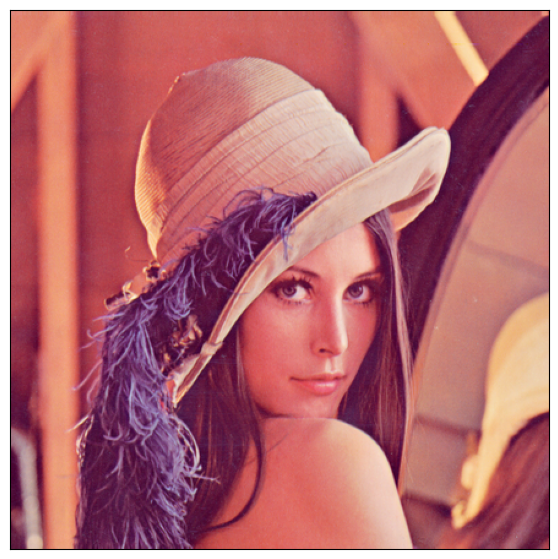

In [1]:
import serket as sk
import imageio
import jax
import jax.numpy as jnp
import jax.random as jr
from matplotlib import pyplot as plt

url = "https://upload.wikimedia.org/wikipedia/en/thumb/7/7d/Lenna_%28test_image%29.png/440px-Lenna_%28test_image%29.png"
image = imageio.v2.imread(url).astype(jnp.float32) / 255.0
plt.figure(figsize=(7, 7))
plt.imshow(image)
plt.yticks([])
plt.xticks([])

## Single image augmentation composition

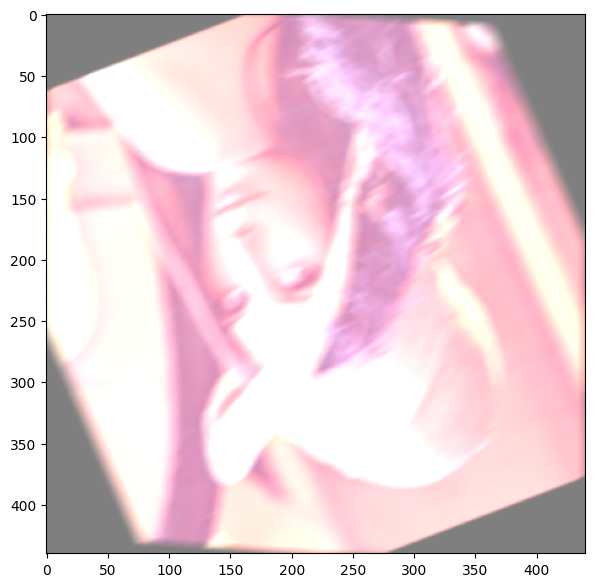

In [2]:
seq = sk.Sequential(
    # lets start with random flips
    sk.image.RandomHorizontalFlip2D(rate=0.5),
    sk.image.RandomVerticalFlip2D(rate=0.5),
    # then random rotations between -45 and 45 degrees
    sk.image.RandomRotate2D((-45, 45)),
    # then random shearing between -30 and 30 degrees
    sk.image.RandomVerticalShear2D((-30, 30)),
    # lets add some blur with a 50% chance
    sk.image.GaussianBlur2D(kernel_size=5, sigma=(0.1, 2.0)),
    # and some motion blur, lets use FFT for large kernels
    sk.image.FFTMotionBlur2D(kernel_size=15, angle=30),
    # lets add one of the following
    sk.RandomChoice(
        sk.image.AdjustBrightness2D(factor=0.5),
        sk.image.AdjustContrast2D(factor=0.5),
        sk.image.AdjustSigmoid2D(gain=10, cutoff=0.5),
    ),
)

# apply the sequence to the image
aug_image = image.transpose(2, 0, 1)  # HWC -> CHW
aug_image = seq(aug_image, key=jr.PRNGKey(1))
aug_image = aug_image.transpose(1, 2, 0)  # CHW -> HWC
plt.figure(figsize=(7, 7))
plt.imshow(aug_image)

## One-to-many augmentations

Using `jax.vmap`, one-to-many augmentations can be made by vectorizing over the RNG key. The following code demonstrate this.

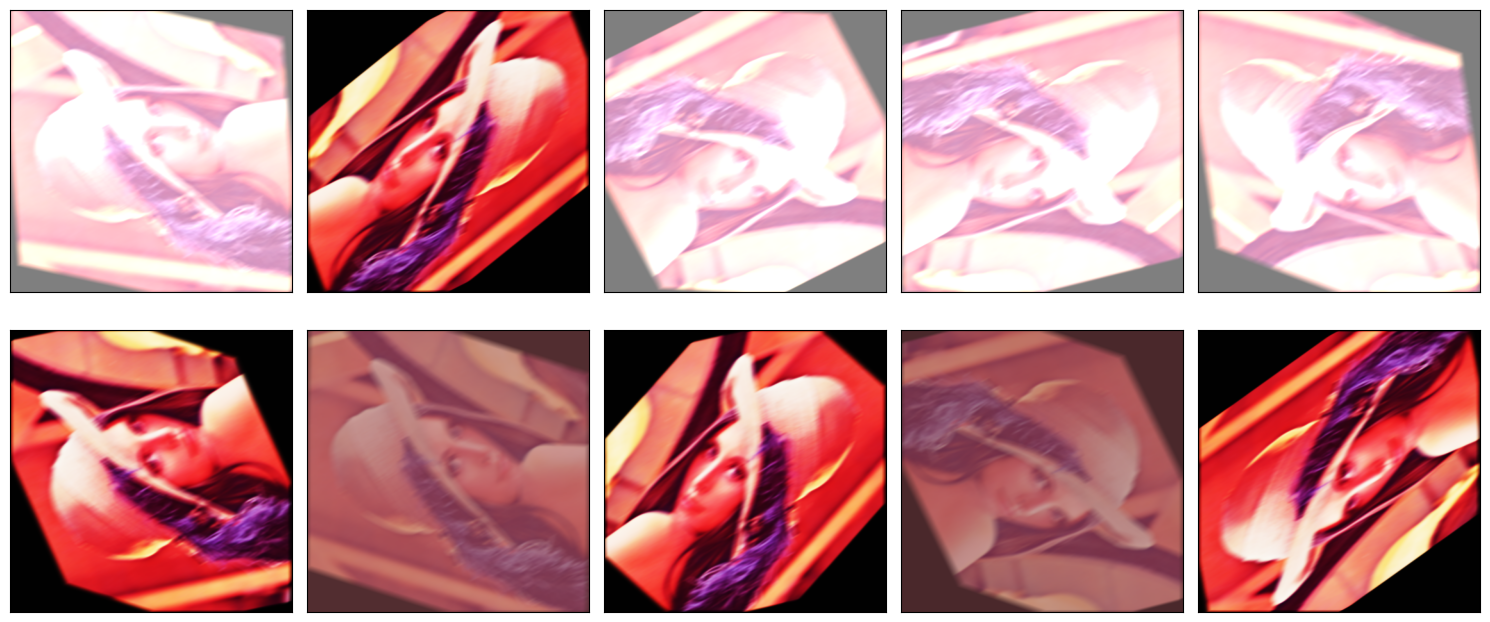

In [3]:
# lets create 10 different augmented images from the same image
keys = jr.split(jr.PRNGKey(1), 10)
image_ = image.transpose(2, 1, 0)  # HWC -> CHW


@jax.vmap
def one_to_many_augmentation(key):
    # CHW -> HWC
    return (seq(image_, key=key).transpose(1, 2, 0) * 255).astype(jnp.uint8)


aug_images = one_to_many_augmentation(keys)
fig, axes = plt.subplots(2, 5, figsize=(15, 7))

for i, ax in enumerate(axes.flat):
    ax.imshow(aug_images[i])
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

## Many-to-many augmentation

In case augmentation is done on multiple images,then `jax.vmap` is used to vectorize over images and keys to create unique augmentation for each image.

In this example for each image 5 augmentation is done.

In [4]:
url = "https://upload.wikimedia.org/wikipedia/en/thumb/7/7d/Lenna_%28test_image%29.png/440px-Lenna_%28test_image%29.png"
lenna = imageio.v2.imread(url).astype(jnp.float32).transpose(2, 1, 0) / 255.0
lenna = sk.nn.Resize2D((256, 256))(lenna)

url = "https://upload.wikimedia.org/wikipedia/commons/2/27/CairoEgMuseumTaaMaskMostlyPhotographed.jpg"
tut = imageio.v2.imread(url).astype(jnp.float32).transpose(2, 1, 0) / 255.0
tut = sk.nn.Resize2D((256, 256))(tut)

url = "https://upload.wikimedia.org/wikipedia/commons/1/1f/Nofretete_Neues_Museum.jpg"
nefertiti = imageio.v2.imread(url).astype(jnp.float32).transpose(2, 1, 0) / 255.0
nefertiti = sk.nn.Resize2D((256, 256))(nefertiti)

# lets create a batch of images
batch = jnp.stack([lenna, tut, nefertiti], axis=0)
# and a batch of keys
keys = jr.split(jr.PRNGKey(1), 3)


@jax.jit
@jax.vmap
def many_to_many(image, key):
    # for each image in the batch, create 5 augmented images
    @jax.vmap
    def one_to_many_augmentation(key):
        return (seq(image, key=key).transpose(1, 2, 0) * 255).astype(jnp.uint8)

    return one_to_many_augmentation(jr.split(key, 5))


aug_batch = sk.nn.Flatten(start_dim=0, end_dim=1)(many_to_many(batch, keys))

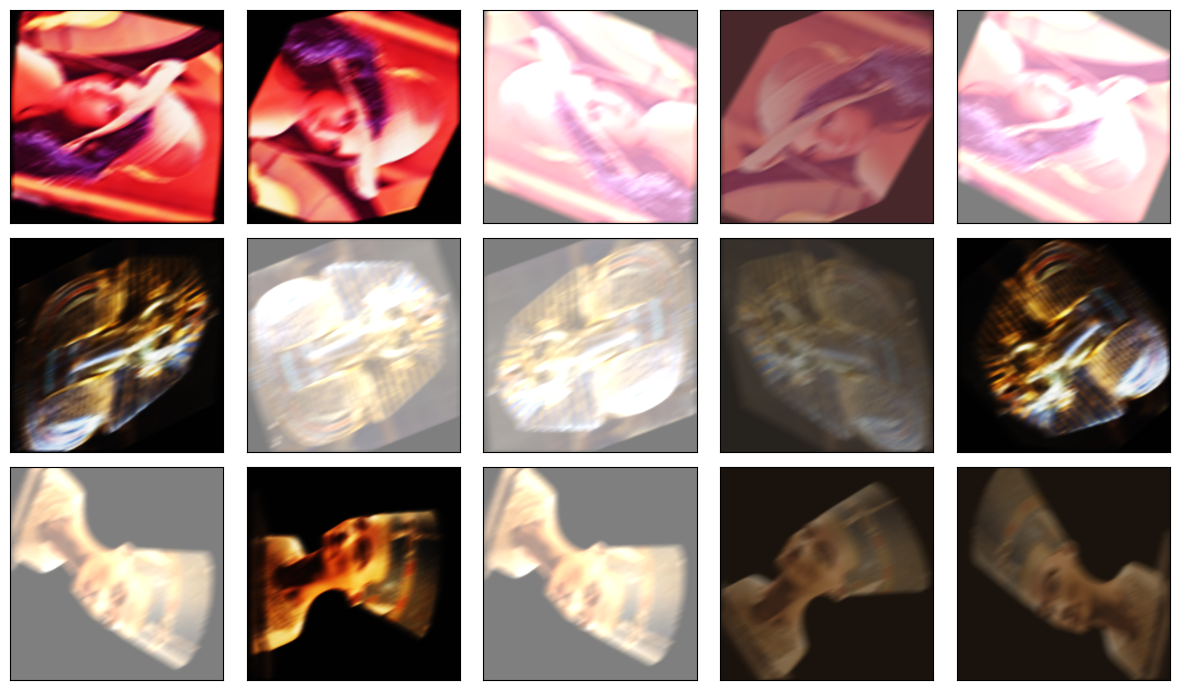

In [5]:
fig, axes = plt.subplots(3, 5, figsize=(12, 7))

for i, ax in enumerate(axes.flat):
    ax.imshow(aug_batch[i])
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()